# Importing Libraries and Preoprocessing of Data
**(The Sample size is 10 Times of Fraud Data size)**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
df['Time'] = scaler.fit_transform(df[['Time']])

fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0].sample(n=len(fraud) * 10, random_state=42)
df_balanced = pd.concat([fraud, non_fraud])

X = df_balanced.drop('Class', axis=1)
y = df_balanced['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Training 3 Models

In [24]:
dtree = DecisionTreeClassifier(random_state=42)
dtree_params = {'max_depth': [4, 6, 8], 'min_samples_split': [2, 5]}
dtree_grid = GridSearchCV(dtree, dtree_params, cv=5, scoring='roc_auc')
dtree_grid.fit(X_train, y_train)
dtree_best = dtree_grid.best_estimator_

rfc = RandomForestClassifier(random_state=42)
rfc_params = {'n_estimators': [100, 200], 'max_depth': [6, 8], 'min_samples_split': [2, 5]}
rfc_grid = GridSearchCV(rfc, rfc_params, cv=3, scoring='roc_auc')
rfc_grid.fit(X_train, y_train)
rfc_best = rfc_grid.best_estimator_

gbc = GradientBoostingClassifier(random_state=42)
gbc_params = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
gbc_grid = GridSearchCV(gbc, gbc_params, cv=3, scoring='roc_auc')
gbc_grid.fit(X_train, y_train)
gbc_best = gbc_grid.best_estimator_


# Top 10 Feature Importance

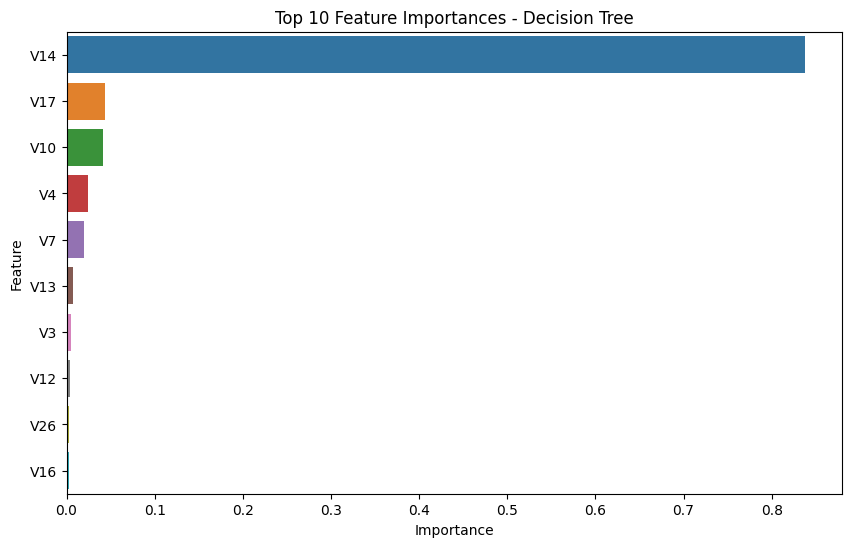

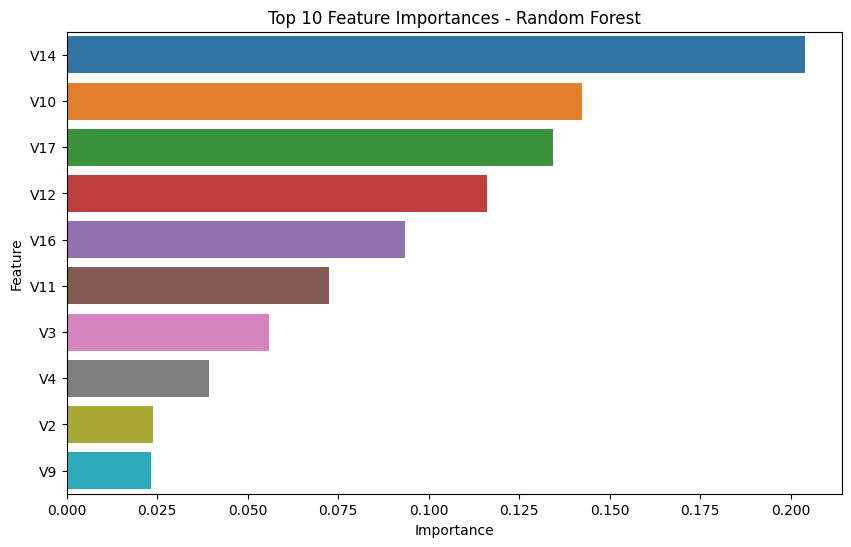

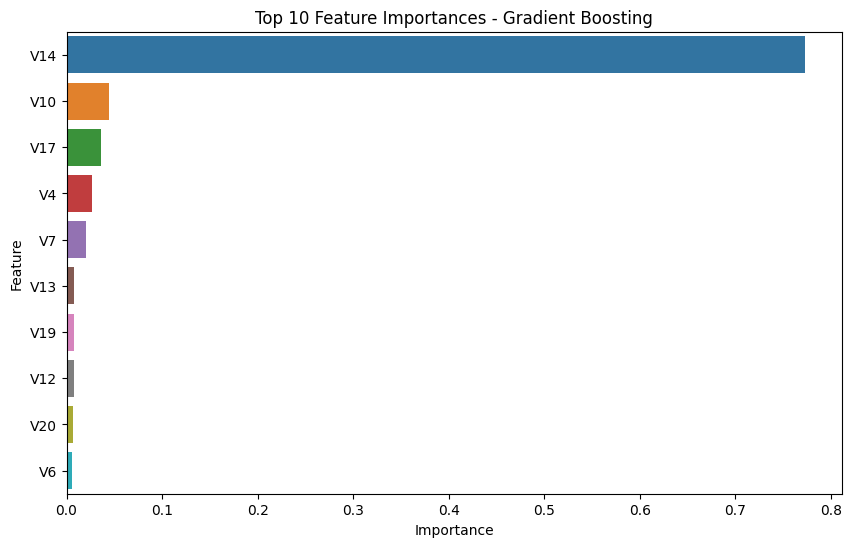

In [28]:
def plot_top_features(model, model_name):
    importances = pd.Series(model.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=False)[:10]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances.values, y=importances.index)
    plt.title(f"Top 10 Feature Importances - {model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

plot_top_features(dtree_best, "Decision Tree")
plot_top_features(rfc_best, "Random Forest")
plot_top_features(gbc_best, "Gradient Boosting")



# Model Comparison

In [29]:
from tabulate import tabulate

models = {
    "Decision Tree": dtree_best,
    "Random Forest": rfc_best,
    "Gradient Boosting": gbc_best
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    results.append([
        name,
        f"{roc:.4f}",
        f"{f1:.4f}",
        f"{precision:.4f}",
        f"{recall:.4f}"
    ])

headers = ["Model", "ROC AUC", "F1 Score", "Precision", "Recall"]
print(tabulate(results, headers=headers, tablefmt="fancy_grid"))


╒═══════════════════╤═══════════╤════════════╤═════════════╤══════════╕
│ Model             │   ROC AUC │   F1 Score │   Precision │   Recall │
╞═══════════════════╪═══════════╪════════════╪═════════════╪══════════╡
│ Decision Tree     │    0.9424 │     0.9032 │      0.9545 │   0.8571 │
├───────────────────┼───────────┼────────────┼─────────────┼──────────┤
│ Random Forest     │    0.9818 │     0.9239 │      0.9884 │   0.8673 │
├───────────────────┼───────────┼────────────┼─────────────┼──────────┤
│ Gradient Boosting │    0.9865 │     0.8995 │      0.9341 │   0.8673 │
╘═══════════════════╧═══════════╧════════════╧═════════════╧══════════╛


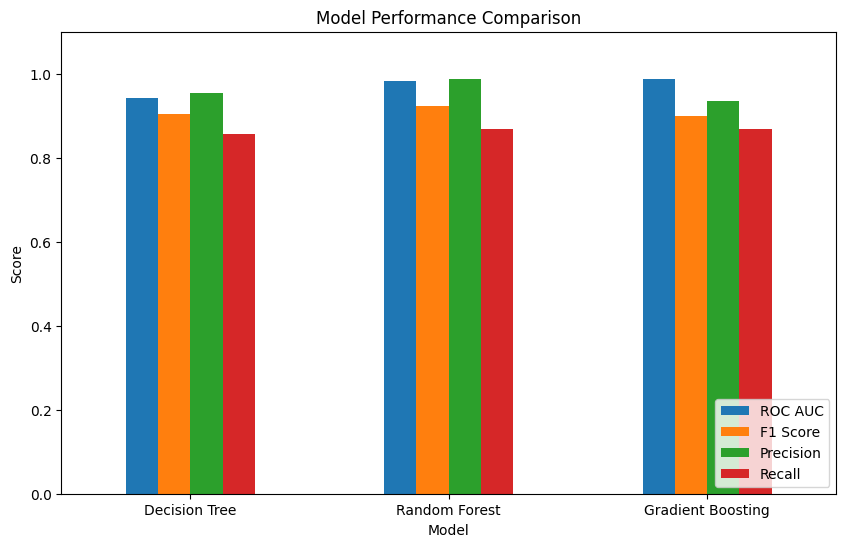

In [27]:
results_df.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.legend(loc="lower right")
plt.xticks(rotation=0)
plt.show()
